In [2]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests
using PyPlot


In [3]:
using BAT

In [4]:
JLD2.@load "../../data/Benchmark-4/mixture_model-2.jld2" mixture_model

1-element Vector{Symbol}:
 :mixture_model

In [5]:

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

In [6]:
function plot_tree(tree, axes::Array{Int64,1}, plot_ax; kwargs...)
    if tree.terminated_leaf == true
        r = matplotlib.patches.Rectangle([tree.bounds[axes[1],1],tree.bounds[axes[2],1]], tree.bounds[axes[1],2]-tree.bounds[axes[1],1], tree.bounds[axes[2],2]-tree.bounds[axes[2],1], fill=false, linewidth=0.8, color="black", alpha=1,; kwargs...,) #alpha=0.0, facecolor=color[i], edgecolor='k', linewidth=2.0)
        plot_ax.add_patch(r)
    else
        plot_tree(tree.left_child, axes, plot_ax; kwargs...)
        plot_tree(tree.right_child, axes, plot_ax; kwargs...)
    end
end

plot_tree (generic function with 1 method)

In [7]:
prior = NamedTupleDist(a = [Uniform(-1000,1000), Uniform(-1000,1000)])

likelihood = let model = mixture_model
    params -> LogDVal(logpdf(model, params.a))
end

posterior = PosteriorDensity(likelihood, prior);

In [8]:
iid_distributions = NamedTupleDist(a = mixture_model,)
samples_iid = bat_sample(iid_distributions, IIDSampling(nsamples=10^6)).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [9]:
JLD2.@load "../../data/Benchmark-4/samples-sp-model-4.jld2" output_sp

samples_sp = output_sp.result;

In [10]:
function make_2d_hist(samples, ind1, ind2; bins=100)
    
    smpls_flat = flatview(unshaped.(samples.v))
    smpls_w = samples.weight
    
    if length(bins) > 1
        binsx, binsy = bins
    else
        binsx = range(minimum(smpls_flat[ind1,:]), maximum(smpls_flat[ind1,:]), length=bins)
        binsy = range(minimum(smpls_flat[ind2,:]), maximum(smpls_flat[ind2,:]), length=bins)
    end
    
    histogram2D = fit(Histogram, (smpls_flat[ind1,:],smpls_flat[ind2,:]), weights(smpls_w), (binsx, binsy))
    histogram_1Dx = fit(Histogram, smpls_flat[ind1,:], weights(smpls_w), binsx)
    histogram_1Dy = fit(Histogram, smpls_flat[ind2,:], weights(smpls_w), binsy)
    
    histogram2D = normalize(histogram2D, mode=:probability)
    histogram_1Dx = normalize(histogram_1Dx, mode=:probability)
    histogram_1Dy = normalize(histogram_1Dy, mode=:probability)
    
    return (res = histogram2D, x = histogram_1Dx, y = histogram_1Dy)
end

make_2d_hist (generic function with 1 method)

In [55]:
xrange = range( -40, 13, length=350 )
yrange = range( -25, 22, length=350)
hist_2 = make_2d_hist(samples_sp, 1,2, bins=(xrange, yrange));
hist_iid = make_2d_hist(samples_iid, 1,2, bins=(xrange, yrange));

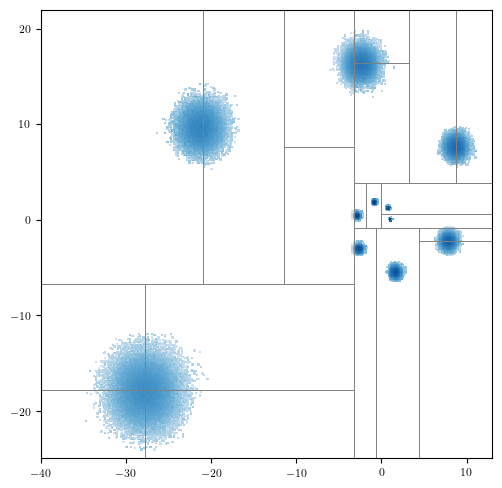

(-25.0, 22.0)

In [56]:
min = (-25, -15)
max = (15, 15)

hist_main = hist_2.res

hist_small = make_2d_hist(samples_iid, 1,2, bins=(range(min[1], max[1], length=100), range(min[2], max[2], length=100))).res

fig, ax1 = plt.subplots(figsize=(5.826767123287671, 5.826767123287671),)

fig.subplots_adjust(hspace=0.00, wspace=0.00)

ax1.pcolormesh(midpoints(hist_main.edges[1]), midpoints(hist_main.edges[2]), log.(hist_main.weights'), cmap="Blues") #log.(hist_main.weights')

plot_tree(output_sp.part_tree, [1,2], ax1, linewidth=0.6, color=:gray, alpha=1)

for i in output_sp.resampled_trees
    plot_tree(i, [1,2], ax1, linewidth=0.6, color=:red, alpha=1)
end

ax1.arrow(-10.0,
    25.0,
    -10,
    150,
    length_includes_head = true,
    head_width=10,
    linewidth=0.8,
    head_length=10,
    color = :red,
    head_starts_at_zero="true",
    facecolor="red")

ax1.set_xlim(xrange[1], xrange[end])
ax1.set_ylim(yrange[1], yrange[end])


In [57]:
# JLD2.@load "../../data/Benchmark-4/result-4-c.jld2" result
# res_1 = result


# evvals = res_1.evid
    
# truth = 2.5000000000000018e-5

# evid_vals = [i.val for i in evvals] ./ truth
# evid_errors = [i.err for i in evvals] ./ truth;

# burnin = MCMCMultiCycleBurnin(
#     max_ncycles = 40,
#     nsteps_per_cycle = 20000
# )

# burnin_1 = MCMCMultiCycleBurnin(
#     max_ncycles = 30,
#     nsteps_per_cycle = 1000
# )

# tuning = AdaptiveMHTuning(α = ClosedInterval(0.03, 0.10))

# mcmc = MCMCSampling(mcalg = MetropolisHastings(tuning=tuning,), nchains=6, nsteps = 5*10^4, trafo = NoDensityTransform(), strict=false, burnin=burnin)

# mcmc_exp = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 680, nchains=35, trafo = NoDensityTransform(), strict=false, burnin=burnin_1)

# integrator = AHMIntegration(  
#         whitening= CholeskyPartialWhitening(), #CholeskyPartialWhitening(),
# #         autocorlen= GeyerAutocorLen(),
# #         volumetype = :HyperRectangle,
#          max_startingIDs = 30000,
#          max_startingIDs_fraction = 20.,
# #         rect_increase = 0.1,
# #         warning_minstartingids = 16,
# #         dotrimming = true,
# #         uncertainty= [:cov]
#     )

# # 3*10^4
# algorithm_1 = PartitionedSampling(sampler = mcmc, npartitions=20, exploration_sampler=mcmc_exp, integrator=integrator, nmax_resampling=5)


# @time output_sp = bat_sample(posterior, algorithm_1);

In [58]:
# fig, ax1 = plt.subplots(figsize=(5.0, 5.0),)
# ax1.errorbar(1:length(evid_vals), evid_vals, yerr = evid_errors, capsize=3., fmt=".")
# ax1.axhline(1.0, color=:red)
# # 
# ax1.set_xlabel("Repetition Index")
# ax1.set_ylabel("Ratio to Truth")

# ax1.set_ylim(0.95, 1.05)

In [59]:
# sum(abs.(evid_vals .- 1) .< evid_errors) ./ length(evid_errors)

In [60]:
# JLD2.@save "../../data/Benchmark-4/evidence-res.jld2" evid_vals evid_errors

JLD2.@load "../../data/Benchmark-4/evidence-res.jld2" evid_vals evid_errors;

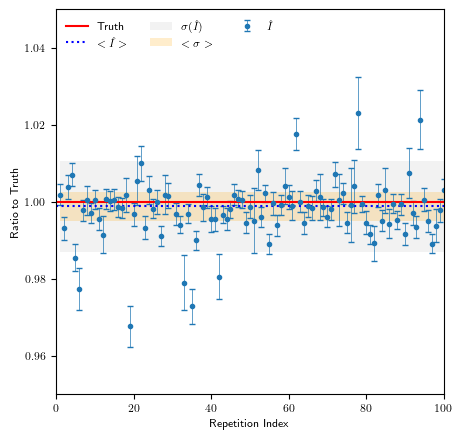

(0.0, 100.0)

In [61]:
fig, ax1 = plt.subplots(figsize=(5.0, 5.0),)

ax1.errorbar(1:length(evid_vals), evid_vals, yerr = evid_errors, lw=0.5, capsize=2., fmt=".", label=L"\hat{I}")

ax1.fill_between(1:length(evid_vals), mean(evid_vals) - std(evid_vals), mean(evid_vals) + std(evid_vals), color=:gray, lw=0.0, zorder=-1, alpha=0.1, label=L"\sigma(\hat{I})")
ax1.fill_between(1:length(evid_vals), mean(evid_vals) - mean(evid_errors), mean(evid_vals) + mean(evid_errors), color=:orange, lw=0.0, zorder=-1, alpha=0.2, label=L"<\sigma>")
ax1.axhline(1.0, color=:red, label="Truth")
ax1.axhline(mean(evid_vals), color=:blue, ls=:dotted, label=L"<\hat{I}>")


ax1.legend(framealpha=0.0, ncol=3, loc="upper left")

ax1.set_xlabel("Repetition Index")
ax1.set_ylabel("Ratio to Truth")

ax1.set_ylim(0.95, 1.05)
ax1.set_xlim(0, 100)


In [62]:
sum(abs.(evid_vals .- 1) .< evid_errors) ./ length(evid_errors)

0.48

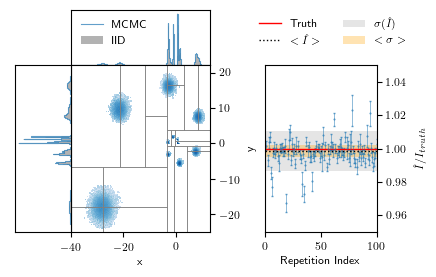

In [92]:
fig = plt.figure(figsize=(4.667538397675384, 2.8846973735586108),)

fig.subplots_adjust(hspace=0.00, wspace=0.00)

ax2 = plt.subplot2grid((4, 13), (0, 2), rowspan=1, colspan=5,  yticklabels=[],  yticks=[], xticks=[],) # upper marginal
ax1 = plt.subplot2grid((4, 13), (1, 2), rowspan=3, colspan=5, )
ax3 = plt.subplot2grid((4, 13), (1, 0), rowspan=3, colspan=2,  yticklabels=[],  yticks=[], xticks=[], xticklabels=[], )
ax4 = plt.subplot2grid((4, 13), (1, 9), rowspan=4, colspan=5,  )

ax1.pcolormesh(midpoints(hist_main.edges[1]), midpoints(hist_main.edges[2]), log.(hist_main.weights'), cmap="Blues", rasterized=true)

# ax2.step(midpoints(hist_iid.x.edges[1]), hist_iid.x.weights, lw=1., color=:red)
ax2.fill_between(midpoints(hist_iid.x.edges[1]), hist_iid.x.weights,  color=:gray, step=:pre, alpha=0.6,  lw=0.0,  label="IID")
ax2.step(midpoints(hist_2.x.edges[1]), hist_2.x.weights, lw=0.8, ls=:solid, label="MCMC", alpha=0.7)

# ax3.step(hist_iid.y.weights, midpoints(hist_iid.y.edges[1]), lw=1., color=:red)
ax3.fill_between(hist_iid.y.weights, midpoints(hist_iid.y.edges[1]),  step=:pre, color=:gray, lw=0.0, alpha=0.6,)
ax3.step(hist_2.y.weights, midpoints(hist_2.y.edges[1]), lw=0.8, ls=:solid, alpha=0.7)
ax3.invert_xaxis()

# proxy = plt.Rectangle(min, max[1] - min[1], max[2] - min[2], fc = "None", ec=:red, ls=:solid, lw=0.5, )
# ax1.add_patch(proxy)

plot_tree(output_sp.part_tree, [1,2], ax1, linewidth=0.5, color=:gray, alpha=1)

ax1.arrow(-10.0,
    25.0,
    -10,
    150,
    length_includes_head = true,
    head_width=10,
    linewidth=0.8,
    head_length=10,
    color = :red,
    head_starts_at_zero="true",
    facecolor="yellow")


ax4.errorbar(1:length(evid_vals), evid_vals, yerr = evid_errors, alpha=0.7, lw=0.5, capsize=1., ms=1, fmt=".")

ax4.fill_between(1:length(evid_vals), mean(evid_vals) - std(evid_vals), mean(evid_vals) + std(evid_vals), color=:gray, lw=0.0, zorder=-1, alpha=0.2, label=L"\sigma(\hat{I})")
ax4.fill_between(1:length(evid_vals), mean(evid_vals) - mean(evid_errors), mean(evid_vals) + mean(evid_errors), color=:orange, lw=0.0, zorder=-1, alpha=0.3, label=L"<\sigma>")
ax4.axhline(1.0, color=:red, lw=1, label="Truth")
ax4.axhline(mean(evid_vals), color=:k, lw=1, ls=:dotted, label=L"<\hat{I}>", zorder=3)


ax4.legend(framealpha=0.0, ncol=2, loc="upper left", bbox_to_anchor=(-0.15, 1.25, 1., .102))


ax4.set_xlabel("Repetition Index")
ax4.set_ylabel(L"\hat{I}/I_{truth}")

ax4.set_ylim(0.95, 1.05)
ax4.set_xlim(0, 100)

ax4.yaxis.set_label_position("right")
ax1.yaxis.set_label_position("right")

ax2.legend(loc="upper left", framealpha=0.0,)

ax2.set_ylim(bottom=0.0)
ax2.set_xlim(xrange[1], xrange[end])

ax3.set_xlim(right=0.0)
ax3.set_ylim(yrange[1], yrange[end])

ax1.set_xlim(xrange[1], xrange[end])
ax1.set_ylim(yrange[1], yrange[end])


ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax1.yaxis.tick_right()
ax1.yaxis.set_ticks_position("both")

ax4.yaxis.tick_right()
ax4.yaxis.set_ticks_position("right")

# fig.savefig("../../plots/example-f.pdf", bbox_inches = "tight")

In [112]:
min = (-4, -4.2)
max = (2, 3)
hist_small = make_2d_hist(samples_sp, 1,2, bins=(range(min[1], max[1], length=100), range(min[2], max[2], length=100))).res;

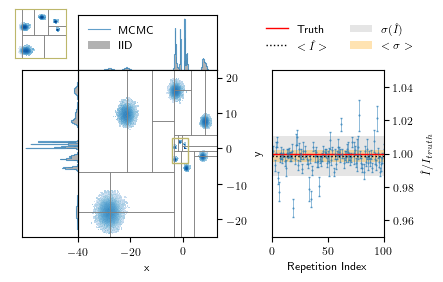

In [187]:
fig = plt.figure(figsize=(4.667538397675384, 2.8846973735586108),)

fig.subplots_adjust(hspace=0.00, wspace=0.00)

ax2 = plt.subplot2grid((4, 13), (0, 2), rowspan=1, colspan=5,  yticklabels=[],  yticks=[], xticks=[],) # upper marginal
ax1 = plt.subplot2grid((4, 13), (1, 2), rowspan=3, colspan=5, )
ax3 = plt.subplot2grid((4, 13), (1, 0), rowspan=3, colspan=2,  yticklabels=[],  yticks=[], xticks=[], xticklabels=[], )
ax4 = plt.subplot2grid((4, 13), (1, 9), rowspan=4, colspan=5,  )

ax1.pcolormesh(midpoints(hist_main.edges[1]), midpoints(hist_main.edges[2]), log.(hist_main.weights'), cmap="Blues", rasterized=true)

# ax2.step(midpoints(hist_iid.x.edges[1]), hist_iid.x.weights, lw=1., color=:red)
ax2.fill_between(midpoints(hist_iid.x.edges[1]), hist_iid.x.weights,  color=:gray, step=:pre, alpha=0.6,  lw=0.0,  label="IID")
ax2.step(midpoints(hist_2.x.edges[1]), hist_2.x.weights, lw=0.8, ls=:solid, label="MCMC", alpha=0.7)

# ax3.step(hist_iid.y.weights, midpoints(hist_iid.y.edges[1]), lw=1., color=:red)
ax3.fill_between(hist_iid.y.weights, midpoints(hist_iid.y.edges[1]),  step=:pre, color=:gray, lw=0.0, alpha=0.6,)
ax3.step(hist_2.y.weights, midpoints(hist_2.y.edges[1]), lw=0.8, ls=:solid, alpha=0.7)
ax3.invert_xaxis()

# proxy = plt.Rectangle(min, max[1] - min[1], max[2] - min[2], fc = "None", ec=:red, ls=:solid, lw=0.5, )
# ax1.add_patch(proxy)

plot_tree(output_sp.part_tree, [1,2], ax1, linewidth=0.5, color=:gray, alpha=1)

ax4.errorbar(1:length(evid_vals), evid_vals, yerr = evid_errors, alpha=0.7, lw=0.5, capsize=1., ms=1, fmt=".")

ax4.fill_between(1:length(evid_vals), mean(evid_vals) - std(evid_vals), mean(evid_vals) + std(evid_vals), color=:gray, lw=0.0, zorder=-1, alpha=0.2, label=L"\sigma(\hat{I})")
ax4.fill_between(1:length(evid_vals), mean(evid_vals) - mean(evid_errors), mean(evid_vals) + mean(evid_errors), color=:orange, lw=0.0, zorder=-1, alpha=0.3, label=L"<\sigma>")
ax4.axhline(1.0, color=:red, lw=1, label="Truth")
ax4.axhline(mean(evid_vals), color=:k, lw=1, ls=:dotted, label=L"<\hat{I}>", zorder=3)


ax_add = fig.add_axes([0.11,0.73,0.11,0.17], yticklabels=[],  yticks=[], xticks=[])
ax_add.pcolormesh(midpoints(hist_small.edges[1]), midpoints(hist_small.edges[2]), log.(hist_small.weights'), cmap="Blues")
proxy = plt.Rectangle(min, max[1] - min[1], max[2] - min[2], fc = "None", ec=:darkkhaki, ls=:solid, lw=1, label="Rubidium Section", zorder=3)
ax1.add_patch(proxy)
plot_tree(output_sp.part_tree, [1,2], ax_add, linewidth=0.5, color=:gray, alpha=1)

ax4.legend(framealpha=0.0, ncol=2, loc="upper left", bbox_to_anchor=(-0.15, 1.25, 1., .102))

ax4.set_xlabel("Repetition Index")
ax4.set_ylabel(L"\hat{I}/I_{truth}")

ax4.set_ylim(0.95, 1.05)
ax4.set_xlim(0, 100)

ax4.yaxis.set_label_position("right")
ax1.yaxis.set_label_position("right")

ax2.legend(loc="upper left", framealpha=0.0,)

ax2.set_ylim(bottom=0.0)
ax2.set_xlim(xrange[1], xrange[end])

ax3.set_xlim(right=0.0)
ax3.set_ylim(yrange[1], yrange[end])

ax1.set_xlim(xrange[1], xrange[end])
ax1.set_ylim(yrange[1], yrange[end])

# arrow = matplotlib[:patches][:ConnectionPatch](
#     10,
#     10,
#     coordsA=ax1.transData,
#     coordsB=ax_add.transData,
#     # Default shrink parameter is 0 so can be omitted
#     color="black",
#     arrowstyle="-|>",  # "normal" arrow
#     mutation_scale=30,  # controls arrow head size
#     linewidth=3,
# )

# # fig.patches.append(arrow)
# fig[:add_collection](arrow)

# ax1.arrow(-4.0,
#     3.0,
#     -30.,
#     17.,
#     length_includes_head = true,
#     head_width=2,
#     linewidth=0.8,
#     head_length=2,
#     color = :darkkhaki,
#     head_starts_at_zero="true",
#     facecolor="darkkhaki")

ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax1.yaxis.tick_right()
ax1.yaxis.set_ticks_position("both")

ax4.yaxis.tick_right()
ax4.yaxis.set_ticks_position("right")

ax_add.spines["bottom"].set_color(:darkkhaki)
ax_add.spines["top"].set_color(:darkkhaki)
ax_add.spines["left"].set_color(:darkkhaki)
ax_add.spines["right"].set_color(:darkkhaki)

ax_add.set_xlim(min[1], max[1])
ax_add.set_ylim(min[2], max[2])

#  fig.savefig("../../plots/example-f-b.pdf", bbox_inches = "tight")